## Anomaly Detection

Our first task is to use a Gaussian model to detect if an unlabeled example from a data set should be considered an anomaly. We have a simple 2-dimensional data set to start off with so we can easily visualize what the algorithm is doing. Let's pull in and plot the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline

In [2]:
data = loadmat('data/ex8data1.mat')

In [3]:
X = data['X']

In [4]:
X.shape

(307, 2)

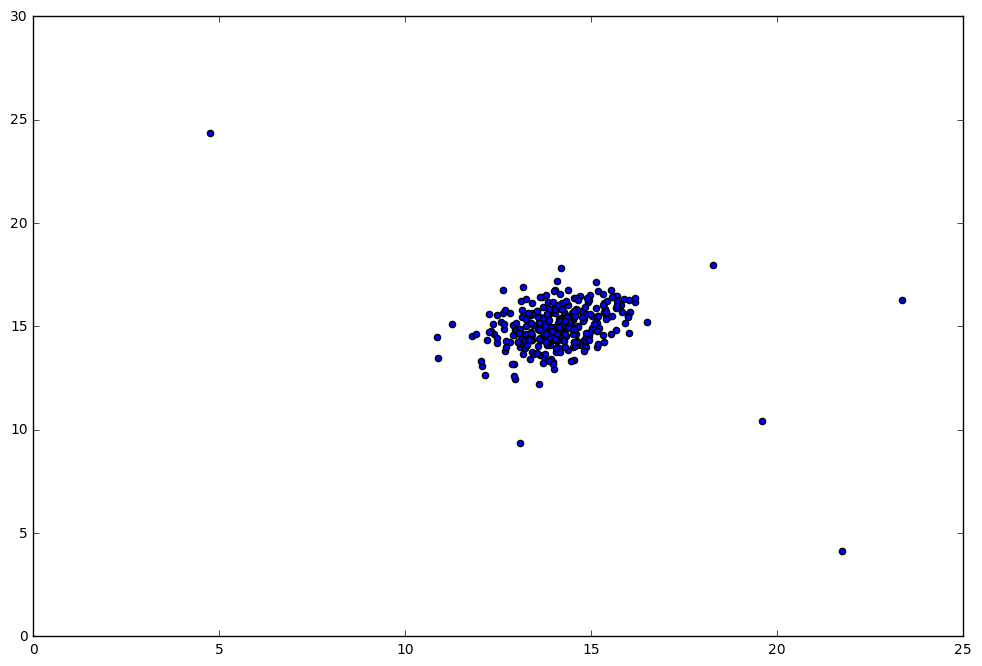

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

It appears that there's a pretty tight cluster in the center with several values further out away from the cluster. In this simple example, these could be considered anomalies. To find out, we're tasked with estimating a Gaussian distribution for each feature in the data. You may recall that to define a probability distribution we need two things - mean and variance. To accomplish this we'll create a simple function that calculates the mean and variance for each feature in our data set.

In [6]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [7]:
mu, sigma = estimate_gaussian(X)

In [8]:
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

Now that we have our model parameters, we need to determine a probability threshold which indicates that an example should be considered an anomaly. To do this, we need to use a set of labeled validation data (where the true anomalies have been marked for us) and test the model's performance at identifying those anomalies given different threshold values.

In [9]:
Xval = data['Xval']
yval = data['yval']

In [10]:
Xval.shape, yval.shape

((307, 2), (307, 1))

We also need a way to calculate the probability that a data point belongs to a normal distribution given some set of parameters. Fortunately SciPy has this built-in.

In [11]:
from scipy import stats

In [12]:
dist = stats.norm(mu[0], sigma[0])

In [13]:
dist.pdf(X[:,0])[0:50]

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

In case it isn't clear, we just calculated the probability that each of the first 50 instances of our data set's first dimension belong to the distribution that we defined earlier by calculating the mean and variance for that dimension. Essentially it's computing how far each instance is from the mean and how that compares to the "typical" distance from the mean for this data.

Let's compute and save the probability density of each of the values in our data set given the Gaussian model parameters we calculated above.

In [14]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

In [15]:
p.shape

(307, 2)

We also need to do this for the validation set (using the same model parameters). We'll use these probabilities combined with the true label to determine the optimal probability threshold to assign data points as anomalies.

In [16]:
pval = np.zeros((X.shape[0], X.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

Next, we need a function that finds the best threshold value given the probability density values and true labels. To do this we'll calculate the F1 score for varying values of epsilon. F1 is a function of the number of true positives, false positives, and false negatives.

In [17]:
def select_threshold(pval,yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min())/1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2* precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
            
    return best_epsilon, best_f1

In [18]:
epsilon, f1 = select_threshold(pval, yval)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


In [19]:
epsilon, f1

(0.0095667060059568421, 0.7142857142857143)

Finally, we can apply the threshold to the data set and visualize the results.

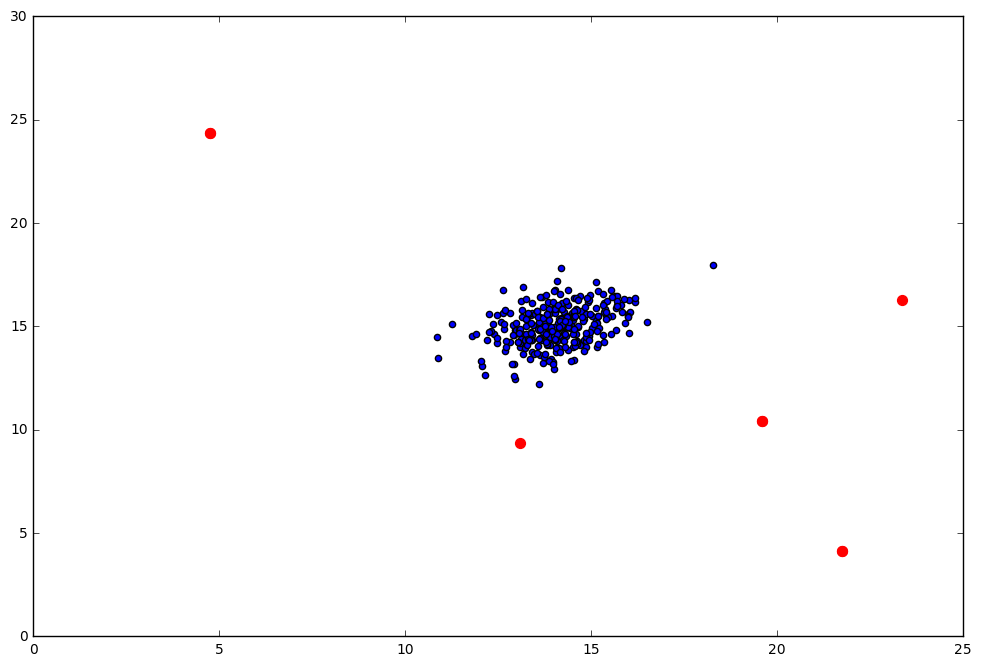

In [20]:
# indexes of values considered to be outliers
outliers = np.where(p < epsilon)

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()

The points in red are the ones that were flagged as outliers. Visually these seem pretty reasonable. The top right point that has some separation (but was not flagged) may be an outlier too, but it's fairly close. There's another example in the text of applying this to a higher-dimensional data set, but since it's a trivial extension of the two-dimensional example we'll move on to the last section.

## Collaborative Filtering

Recommendation engines use item and user-based similarity measures to examine a user's historical preferences to make recommendations for new "things" the user might be interested in. In this exercise we'll implement a particular recommendation algorithm called collaborative filtering and apply it to a data set of movie ratings. Let's first load and examine the data we'll be working with.

In [21]:
data = loadmat('data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y is a (number of movies x number of users) array containing ratings from 1 to 5. R is an "indicator" array containing binary values indicating if a user has rated a movie or not. Both should have the same shape.

In [22]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

We can look at the average rating for a movie by averaging over a row in Y for indexes where a rating is present.

In [23]:
Y[1,R[1,:]].mean()

2.5832449628844114

Next we're going to implement a cost function for collaborative filtering. Intuitively, the "cost" is the degree to which a set of movie rating predictions deviate from the true predictions. The cost equation is given in the exercise text. It is based on two sets of parameter matrices called X and Theta in the text. These are "unrolled" into the "params" input so that we can use SciPy's optimization package later on. Note that I've included the array/matrix shapes in comments to help illustrate how the matrix interactions work.

In [24]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y) # (1682, 943)
    R = np.matrix(R) # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    #reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features))) # (1682,10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))# (943, 10)
    
    #initialise
    J = 0
    
    error = np.multiply((X * Theta.T) - Y, R) # (1682, 943)
    squared_error = np.power(error, 2) # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In order to test this, we're provided with a set of pre-trained parameters that we can evaluate. To keep the evaluation time down, we'll look at just a small sub-set of the data.

In [25]:
users = 4
movies = 5
features = 3

params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']

X_sub = X[:movies, :features]
Theta_sub = Theta[:users,:features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

This answer matches what the exercise text said we're supposed to get. Next we need to implement the gradient computations. Just like we did with the neural networks implementation in exercise 4, we'll extend the cost function to also compute the gradients.

In [26]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y) # (1682, 943)
    R = np.matrix(R) # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    #reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features))) # (1682,10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))# (943, 10)
    
    #initialise
    J = 0
    X_grad = np.zeros(X.shape) # (1682, 10)
    Theta_grad = np.zeros(Theta.shape) # (943, 10)
    
    #compute cost
    error = np.multiply((X * Theta.T) - Y, R) # (1682, 943)
    squared_error = np.power(error, 2) # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    #calcualte the gradients
    X_grad = error * Theta
    Theta_grad = error.T  * X
    
    #unravel the gradient matrixes into single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [27]:
J, grad = cost(params, Y_sub, R_sub, features)

In [28]:
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

Our next step is to add regularization to both the cost and gradient calculations. We'll create one final regularized version of the function (note that this version includes an additional learning rate parameter called "lambda").

In [29]:
def cost(params, Y, R, num_features, learning_rate):  
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]

    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)

    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)

    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)

    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))

    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)

    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))

    return J, grad

In [30]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5) 

In [31]:
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

This result again matches up with the expected output from the exercise code, so it looks like the regularization is working. Before we train the model, we have one final step. We're tasked with creating our own movie ratings so we can use the model to generate personalized recommendations. A file is provided for us that links the movie index to its title. Let's load the file into a dictionary and use some sample ratings provided in the exercise.

In [32]:
movie_idx = {}
f = open('data/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) -1] = ' '.join(tokens[1:])

In [33]:
ratings = np.zeros((1682,1))

In [34]:
ratings[0] = 4  
ratings[6] = 3  
ratings[11] = 5  
ratings[53] = 4  
ratings[63] = 5  
ratings[65] = 3  
ratings[68] = 5  
ratings[97] = 2  
ratings[182] = 4  
ratings[225] = 5  
ratings[354] = 5

In [35]:
print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))  
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))  

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


We can add this custom ratings vector to the data set so it gets included in the model.

In [36]:
R = data['R']
Y = data['Y']

In [37]:
Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings !=0, axis=1)

We're now ready to train the collaborative filtering model. We're going to normalize the ratings and then run the optimization routine using our cost function, parameter vector, and data matrices at inputs.

In [38]:
from scipy.optimize import minimize

In [52]:
movies = Y.shape[0]  
users = Y.shape[1]  
features = 10  
learning_rate = 10.

X = np.random.random(size=(movies, features))  
Theta = np.random.random(size=(users, features))  
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

Ymean = np.zeros((movies, 1))  
Ynorm = np.zeros((movies, users))

for i in range(movies):  
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate),  
                method='CG', jac=True, options={'maxiter': 500})

In [40]:
fmin

     fun: 38951.84755998029
     jac: array([  3.17610361e-07,   8.30271360e-07,   1.47674357e-08, ...,
        -1.89834025e-07,   4.57607677e-08,   2.74699246e-08])
 message: 'Optimization terminated successfully.'
    nfev: 636
     nit: 424
    njev: 636
  status: 0
 success: True
       x: array([ 0.85033238,  0.61255279, -0.22888525, ...,  0.02832471,
        0.05495042,  0.12405635])

Since everything was "unrolled" for the optimization routine to work properly, we need to reshape our matrices back to their original dimensions.

In [41]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

In [42]:
X.shape, Theta.shape

((1682, 10), (944, 10))

Our trained parameters are now in X and Theta. We can use these to create some recommendations for the user we added earlier.

In [43]:
predictions = X * Theta.T
my_preds = predictions[:,-1] + Ymean
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.],
        [ 5.]])

That gives us an ordered list of the top ratings, but we lost what index those ratings are for. We actually need to use argsort so we know what movie the predicted rating corresponds to.

In [44]:
idx = np.argsort(my_preds, axis=0)[::-1]

In [45]:
movie_idx[312]

'Titanic (1997)'

In [46]:
my_preds[312]

matrix([[ 4.38748041]])

In [47]:
print("Top 10 movie predictions:")  
for i in range(10):  
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.000000000000909 for movie Aiqing wansui (1994).
Predicted rating of 5.00000000000021 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.000000000000018 for movie Santa with Muscles (1996).
Predicted rating of 5.0000000000000036 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 4.999999999999995 for movie They Made Me a Criminal (1939).
Predicted rating of 4.999999999999941 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.999999999999876 for movie Someone Else's America (1995).
Predicted rating of 4.999999999995585 for movie Star Kid (1997).
Predicted rating of 4.9999999999882005 for movie Prefontaine (1997).


Something up. Will have to come back to it